In [1]:
from google import genai
from google.genai import types
from PIL import Image
import json
import requests

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
client = genai.Client()

prompt = "Detect the all of the prominent items in the image. The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000."


In [ ]:
image_path = "test_drawings/output/page_1.png"
image = Image.open(image_path)

config = types.GenerateContentConfig(
  response_mime_type="application/json"
  )

response = client.models.generate_content(model="gemini-2.5-flash",
                                          contents=[image, prompt],
                                          config=config
                                          )

width, height = image.size
bounding_boxes = json.loads(response.text)
bounding_boxes

In [7]:
converted_bounding_boxes = []
for bounding_box in bounding_boxes:
    abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
    abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
    abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
    abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)
    
    converted_bounding_boxes.append({
        "box_2d": [abs_x1, abs_y1, abs_x2, abs_y2],
        "label": bounding_box["label"]
    })

# Print info
print("Image size: ", width, height)
print("Bounding boxes:", converted_bounding_boxes)



Image size:  10800 7200
Bounding boxes: [{'box_2d': [9838, 144, 10670, 273], 'label': 'project_name'}, {'box_2d': [9838, 288, 10357, 352], 'label': 'phase'}, {'box_2d': [9838, 352, 10648, 417], 'label': 'phase'}, {'box_2d': [9838, 518, 10368, 576], 'label': 'project_name'}, {'box_2d': [9838, 576, 10216, 633], 'label': 'address'}, {'box_2d': [9838, 633, 10173, 691], 'label': 'address'}, {'box_2d': [9849, 777, 10562, 957], 'label': 'logo'}, {'box_2d': [9838, 1051, 10346, 1116], 'label': 'company_name'}, {'box_2d': [9838, 1144, 10324, 1195], 'label': 'address'}, {'box_2d': [9838, 1281, 10130, 1332], 'label': 'role'}, {'box_2d': [9838, 1353, 9979, 1432], 'label': 'company_name'}, {'box_2d': [9838, 1432, 10584, 1497], 'label': 'company_name'}, {'box_2d': [9838, 1519, 10335, 1569], 'label': 'address'}, {'box_2d': [9838, 1720, 10130, 1778], 'label': 'role'}, {'box_2d': [9838, 1800, 10530, 1951], 'label': 'company_name'}, {'box_2d': [9838, 1965, 10508, 2016], 'label': 'address'}, {'box_2d': [9

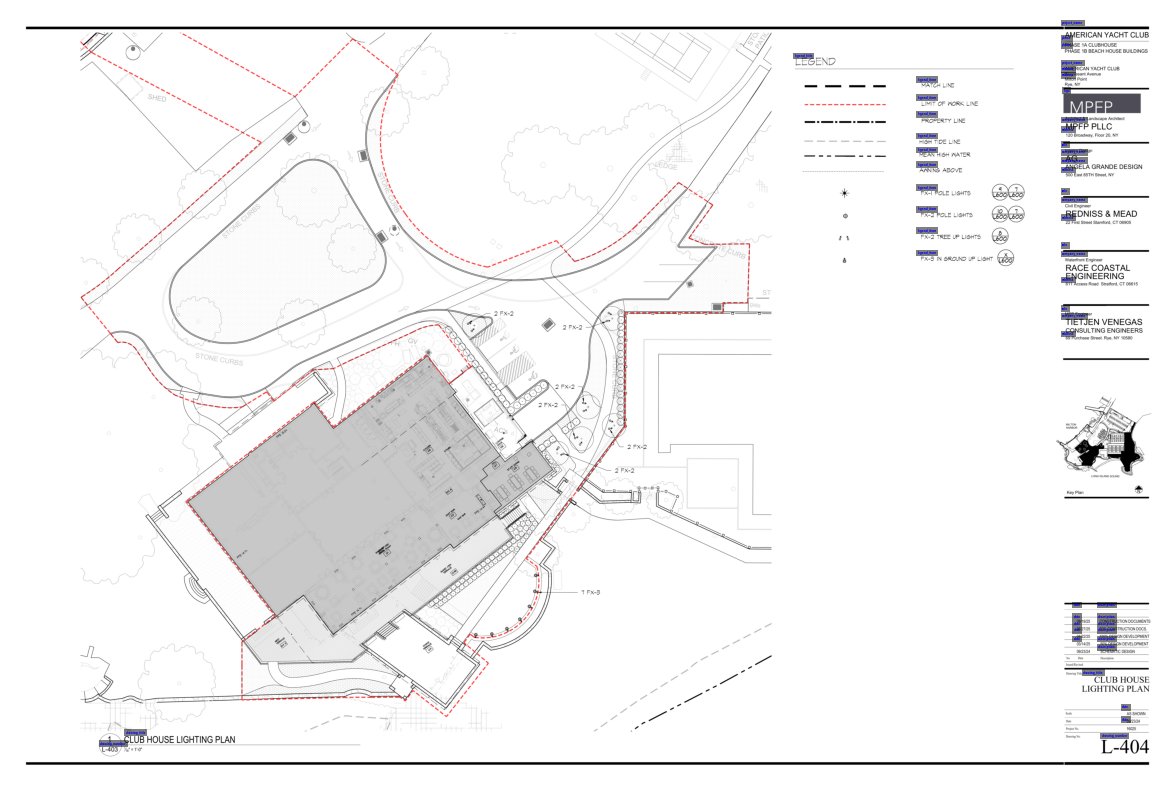

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)

for cb in converted_bounding_boxes:
    x1, y1, x2, y2 = cb["box_2d"]
    label = cb["label"]

    # Red semi-transparent border, no fill
    rect = patches.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        linewidth=2,
        edgecolor=(1, 0, 0, 0.),  # red with alpha 0.6
        facecolor='none'            # no fill
    )
    ax.add_patch(rect)

    # Draw label text above the box
    ax.text(
        x1,                 # left edge of rectangle
        max(y1 - 5, 0),     # slightly above top edge
        label,
        fontsize=2,
        color='blue',
        weight='bold',
        ha='left',           # horizontal alignment: left
        va='bottom',         # vertical alignment: bottom of text
        bbox=dict(facecolor=(0,0,0,0.5), edgecolor='none', pad=1)
    )


plt.axis("off")
plt.tight_layout()

output_path = "test_drawings/bboxes_images/page_1.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

### Asking for context

In [29]:
prompt = "You are an expert architectural plan interpreter. Carefully inspect the image and extract the following information: \
1. Drawing scale (look for written text like 'in given format with inches for foot measurements', '1/8\" = 1'-0\"', '1:100', 'SCALE: 1/4\" = 1'-0\"', or 'Scale in the drawing', or similar). Do NOT assume, estimate, or calculate scale. Only use explicitly written scale. \
2. Sheet or drawing number (any text in title block or annotations specifying sheet number). \
3. Drawing title (any text in title block indicating the title of the drawing). \
If any of these items are not found, return 'not found' for that item. \
Return ONLY in the following JSON format: \
{ \
  \"scale\": \"<found scale or 'Scale not found'>\", \
  \"sheet_number\": \"<sheet or drawing number or 'not found'>\", \
  \"title\": \"<drawing title or 'not found'>\" \
} \
Here is the image: <insert image here> \
"


In [30]:
client = genai.Client()
image_path = "test_drawings/output/page_1.png"
image = Image.open(image_path)

config = types.GenerateContentConfig(
  response_mime_type="application/json"
  )

response = client.models.generate_content(model="gemini-2.5-flash",
                                          contents=[image, prompt],
                                          config=config
                                          )

width, height = image.size
ordered_response= json.loads(response.text)


In [28]:
print("Raw response: ", response.text)
print("\n\n")
print("ordered_response: ", ordered_response)

Raw response:  {
  "scale": "As Indicated",
  "sheet_number": "T1.0",
  "title": "COVER SHEET"
}



ordered_response:  {'scale': 'As Indicated', 'sheet_number': 'T1.0', 'title': 'COVER SHEET'}


In [ ]:
import cv2
import numpy as np

# === Configuration ===
image_path = "test_drawings/output/page_1.png"  # your image file
drawing_scale = '1/16" = 1\'-0"'  # your scale
dpi = 300  # image DPI, optional for pixel to inch conversion
display_scale = 0.1  # scale down factor for display (10x smaller)

# === Parse the scale ===
def parse_scale(scale_str):
    import re
    # Parse left side (drawing length)
    left_match = re.match(r"(\d+)/(\d+)\"", scale_str)
    if left_match:
        numerator, denominator = map(int, left_match.groups())
        drawing_inches = numerator / denominator
    else:
        drawing_inches = float(scale_str.split("\"")[0])

    # Parse right side (real-world length)
    right_match = re.match(r"(\d+)-(\d+)\"?", scale_str.split("=")[1].strip())
    if right_match:
        feet, inches = map(int, right_match.groups())
        real_inches = feet*12 + inches
    else:
        real_inches = 12  # default fallback

    scale_factor = real_inches / drawing_inches
    return drawing_inches, real_inches, scale_factor

drawing_inches, real_inches, scale_factor = parse_scale(drawing_scale)

# === Load original image ===
orig_image = cv2.imread(image_path)
orig_h, orig_w = orig_image.shape[:2]

# === Create scaled display image ===
disp_image = cv2.resize(orig_image, (int(orig_w*display_scale), int(orig_h*display_scale)))
disp_h, disp_w = disp_image.shape[:2]

# === Mouse callback ===
points = []

def draw_line(event, x, y, flags, param):
    global points
    img = param.copy()
    # Map mouse coordinates to original image
    orig_x = int(x / display_scale)
    orig_y = int(y / display_scale)
    
    if event == cv2.EVENT_LBUTTONDOWN:
        points = [(orig_x, orig_y)]
    elif event == cv2.EVENT_LBUTTONUP:
        points.append((orig_x, orig_y))
        # Draw on preview
        cv2.line(img, (int(points[0][0]*display_scale), int(points[0][1]*display_scale)),
                 (int(points[1][0]*display_scale), int(points[1][1]*display_scale)),
                 (0, 0, 255), 2)
        cv2.imshow("Image", img)
        
        # Compute length
        dx = points[1][0] - points[0][0]
        dy = points[1][1] - points[0][1]
        pixel_length = np.sqrt(dx**2 + dy**2)
        
        drawing_unit_length = pixel_length / dpi * drawing_inches  # in drawing inches
        real_world_length = drawing_unit_length * scale_factor   # in real inches
        
        print(f"Pixel length: {pixel_length:.2f} px")
        print(f"Drawing length: {drawing_unit_length:.4f}\"")
        print(f"Real-world length: {real_world_length:.4f}\" ({real_world_length/12:.4f} ft)")

# === Show image ===
cv2.imshow("Image", disp_image)
cv2.setMouseCallback("Image", draw_line, param=disp_image)
print("Draw a line with left mouse button. Release to calculate length.")
cv2.waitKey(0)
cv2.destroyAllWindows()

Draw a line with left mouse button. Release to calculate length.
Pixel length: 1880.66 px
Drawing length: 0.3918"
Real-world length: 75.2266" (6.2689 ft)
Pixel length: 2634.86 px
Drawing length: 0.5489"
Real-world length: 105.3945" (8.7829 ft)
Pixel length: 905.21 px
Drawing length: 0.1886"
Real-world length: 36.2083" (3.0174 ft)
Pixel length: 3821.31 px
Drawing length: 0.7961"
Real-world length: 152.8523" (12.7377 ft)
Pixel length: 1811.35 px
Drawing length: 0.3774"
Real-world length: 72.4541" (6.0378 ft)
Pixel length: 2405.66 px
Drawing length: 0.5012"
Real-world length: 96.2264" (8.0189 ft)
Pixel length: 2460.08 px
Drawing length: 0.5125"
Real-world length: 98.4033" (8.2003 ft)
Pixel length: 3913.69 px
Drawing length: 0.8154"
Real-world length: 156.5478" (13.0456 ft)
Pixel length: 2880.02 px
Drawing length: 0.6000"
Real-world length: 115.2007" (9.6001 ft)
Pixel length: 3966.67 px
Drawing length: 0.8264"
Real-world length: 158.6669" (13.2222 ft)
Pixel length: 2173.13 px
Drawing lengt

In [22]:
import os
from pdf2image import convert_from_path

pdf_path = "test_drawings/BUDR STAMFORD A&E BID ISSUE.pdf"
page_number = int(input("Enter page number to convert (starting from 1): "))

# Get directory of the PDF
pdf_dir = os.path.dirname(pdf_path)

# Create output folder path
output_dir = os.path.join(pdf_dir, "output")

# Create folder if not exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Convert only the specific page
images = convert_from_path(
    pdf_path,
    dpi=300,
    first_page=page_number,
    last_page=page_number
)

# Output file path
output_name = os.path.join(output_dir, f"page_{page_number}.png")

# Save the image
images[0].save(output_name)

print(f"Page {page_number} saved at:\n{output_name}")


Page 1 saved at:
test_drawings/output/page_1.png
